In [70]:
import pandas as pd
import numpy as np
import tensorflow as tf
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import talib
from scipy import stats
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from sklearn.model_selection import train_test_split


#  1. Préparation des Données et Analyse Exploratoire

In [71]:
#Download et Feature
data = yf.download('^GSPC',period='730d', interval='1h', prepost=True)
data = data.droplevel(level=1, axis=1)
data['Volume'] = data['Volume'].mask(data['Volume'] == 0).ffill()
data['Return'] = data['Close'].pct_change(45)*100
data["SMA"] = talib.SMA(data["Close"], timeperiod=45)
data["RSI"] = talib.RSI(data["Close"], timeperiod=45)
data['Volume_Spike'] = (
            data['Volume'] / data['Return'].std()
            ).rolling(45).apply(lambda x: x.iloc[-1] > 2 * x.mean()
        )
data.head()

[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume,Return,SMA,RSI,Volume_Spike
Datetime,,,,,,,,,
2022-05-02 13:30:00+00:00,4156.750000,4159.450195,4105.060059,4130.609863,NaN,NaN,NaN,NaN,NaN
2022-05-02 14:30:00+00:00,4116.180176,4169.810059,4112.589844,4156.339844,345769410.0,NaN,NaN,NaN,NaN
2022-05-02 15:30:00+00:00,4125.979980,4136.310059,4110.609863,4116.640137,260092625.0,NaN,NaN,NaN,NaN
2022-05-02 16:30:00+00:00,4097.819824,4132.799805,4091.899902,4126.109863,245826000.0,NaN,NaN,NaN,NaN
2022-05-02 17:30:00+00:00,4074.939941,4103.589844,4069.649902,4097.850098,264081000.0,NaN,NaN,NaN,NaN


In [ ]:
# Il est important de se demander : pour prédire l'évolution du cours dans les prochains jours,
# est-il plus cohérent de prévoir la variation du prix ou le prix lui-même ?
# Faut-il prédire le prix exact, ou plutôt si le prix va varier de X % ?
# Selon moi, la variation est plus scalabe  et efficient sur différent indice et action en bourse que la valeur absolue.
# En effet, la variation peut être un bon moyen de comparer et d'étudier la correlation entre indice et cours boursier,
# tandis que la valeur absolue du prix ne dispose pas de la même échelle au cours du temps.

In [73]:
fig = make_subplots(rows=1, cols=2, subplot_titles=("Close", "Return"))
fig.add_trace(go.Scatter(x=data.index, y=data["Close"], mode="lines", name="Close", line=dict(color="blue")), row=1, col=1)
fig.add_trace(go.Scatter(x=data.index, y=data["Return"], name="Return", marker_color="blue", mode="lines"), row=1, col=2)
fig.update_layout(
    title="Close and Return",
    xaxis_title="Date",
    height=400,
    showlegend=True
)
fig.show()

In [74]:
data.shape

(6323, 9)

In [ ]:
# Valeurs manquantes
print(data.isnull().sum())
# Il s'agit des valeurs initiales des différents indicateurs qui
# sont calculés en prenant en compte les 45 heures précédents.
# S'il y a moins de 45 heres de données, aucune valeur n'est calculée.

Price
Close            0
High             0
Low              0
Open             0
Volume           1
Return          45
SMA             44
RSI             45
Volume_Spike    45
dtype: int64


In [76]:
data = data.dropna()
data

Price,Close,High,Low,Open,Volume,Return,SMA,RSI,Volume_Spike
Datetime,,,,,,,,,
2022-05-09 13:30:00+00:00,4034.159912,4081.270020,4032.699951,4081.270020,15310000.0,-2.949181,4158.521772,43.546472,0.0
2022-05-09 14:30:00+00:00,4010.709961,4039.280029,4009.340088,4034.209961,417559003.0,-2.562332,4156.177990,42.473974,0.0
2022-05-09 15:30:00+00:00,4041.080078,4050.209961,4003.169922,4010.679932,334837856.0,-2.057691,4154.291325,44.291292,0.0
2022-05-09 16:30:00+00:00,4024.959961,4047.389893,4010.689941,4041.290039,258554000.0,-1.778015,4152.672217,43.544531,0.0
2022-05-09 17:30:00+00:00,4010.040039,4028.159912,4004.350098,4024.979980,287488000.0,-1.592659,4151.229997,42.860495,0.0
...,...,...,...,...,...,...,...,...,...
2025-03-28 15:30:00+00:00,5590.490234,5619.330078,5588.490234,5610.990234,252032104.0,-1.278495,5711.149148,41.200020,0.0
2025-03-28 16:30:00+00:00,5575.049805,5597.080078,5573.939941,5590.470215,245014000.0,-1.551155,5709.197144,40.184009,0.0
2025-03-28 17:30:00+00:00,5581.879883,5591.250000,5574.069824,5575.080078,250043000.0,-0.704796,5708.316697,40.843982,0.0


In [77]:
#Outliers
fig = make_subplots(rows=1, cols=len(data.columns), subplot_titles=data.columns)
for i, col in enumerate(data.columns):
    fig.add_trace(go.Box(y=data[col], name=col), row=1, col=i+1)

fig.update_layout(title_text="Outlier", showlegend=False)
fig.show()

In [78]:
# En finance de marché, les outliers sont souvent significatifs pour étudier le prix du marché.
# On ne les supprime pas.

In [79]:
data.describe()

Price,Close,High,Low,Open,Volume,Return,SMA,RSI,Volume_Spike
count,6278.000000,6278.000000,6278.000000,6278.000000,6.278000e+03,6278.000000,6278.000000,6278.000000,6278.000000
mean,4708.879638,4716.147422,4701.144614,4708.805056,2.833209e+08,0.253370,4703.524380,52.534761,0.031220
std,746.785229,746.719935,746.772334,746.908301,2.931698e+08,2.308761,743.995526,8.462874,0.173926
min,3530.909912,3550.969971,3491.580078,3520.370117,1.730000e+05,-10.851944,3609.128874,27.573251,0.000000
25%,4061.255027,4070.777527,4051.937561,4060.627500,1.915380e+08,-0.975632,4044.718671,46.242078,0.000000
50%,4478.159912,4486.055176,4472.160000,4478.900146,2.467418e+08,0.404355,4470.879449,53.185232,0.000000
75%,5401.277588,5408.267515,5398.830039,5401.365146,3.302735e+08,1.630909,5370.165165,58.931937,0.000000
max,6144.150000,6147.430176,6144.090000,6144.440000,4.192067e+09,8.358298,6108.787751,75.940210,1.000000


Price,Close,High,Low,Open,Volume,Return,SMA,RSI,Volume_Spike
Price,,,,,,,,,
Close,1.000000,0.999915,0.999927,0.999859,0.055499,0.088926,0.996841,0.171054,-0.020740
High,0.999915,1.000000,0.999853,0.999927,0.055600,0.085855,0.997088,0.167006,-0.020840
Low,0.999927,0.999853,1.000000,0.999913,0.055297,0.089758,0.996760,0.171917,-0.020669
Open,0.999859,0.999927,0.999913,1.000000,0.055452,0.086778,0.997006,0.168087,-0.020776
Volume,0.055499,0.055600,0.055297,0.055452,1.000000,-0.031495,0.058539,-0.045389,0.707168
Return,0.088926,0.085855,0.089758,0.086778,-0.031495,1.000000,0.021958,0.815372,-0.017826
SMA,0.996841,0.997088,0.996760,0.997006,0.058539,0.021958,1.000000,0.105358,-0.018882
RSI,0.171054,0.167006,0.171917,0.168087,-0.045389,0.815372,0.105358,1.000000,-0.023378
Volume_Spike,-0.020740,-0.020840,-0.020669,-0.020776,0.707168,-0.017826,-0.018882,-0.023378,1.000000


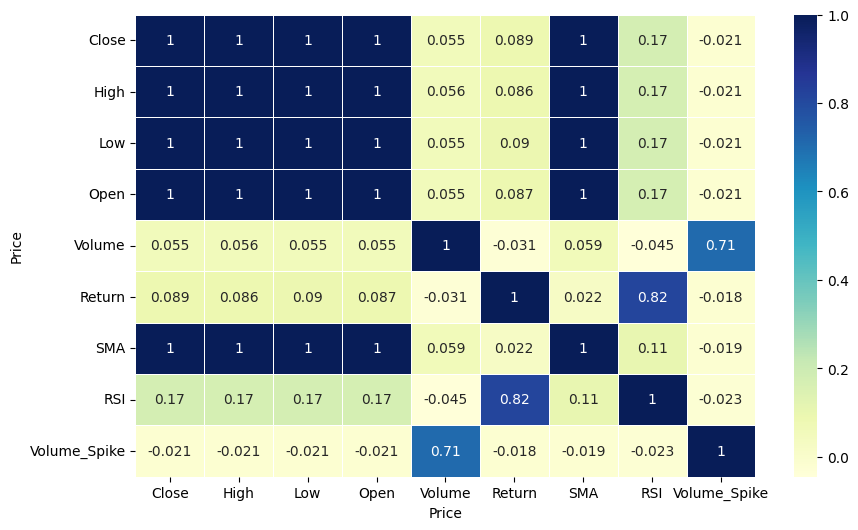

In [ ]:
df_numeric = data.select_dtypes(include=['float64', 'int64'])

# Créer la heatmap uniquement avec les colonnes numériques
plt.figure(figsize=(10, 6))
sns.heatmap(df_numeric.corr(), annot=True, cmap='YlGnBu', cbar=True, linewidths=0.5)
df_numeric.corr()

In [ ]:
# On remarque des plusieurs probleme et chose à faire sur nos features
# Close, High, Low, Open et SMA sont parfaitemetn corrélé entre eux, une de ces features suffit pour notre IA.
# On peut effectuer du features engineering de façon quantitative afin de rajouter de la pertinance.
